<a href="https://colab.research.google.com/github/Gutleyb/MSU.AI-Sandstone_ML/blob/main/Sandstone_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**!!!** Блокнот доступен для работы в режиме `run all`.

Тем не менее, во избежание долгого ожидания выполнения ячеек, в которых осуществляется поиск оптимальных параметров при помощи Optuna, рекомендуется использовать заранее зафиксированные значения `best_params`, пропуская ячейки с использованием Optuna.

# Данные

## Введение

В работе исследуется возможность выделения групп схожих **импульсов термически стимулированной акустической эмиссии (ТАЭ)** на основе параметров импульсов в эксперименте по нагреву образца **метаморфизированного песчаника** методами машинного обучения. Данный образец горной породы был подвергнут предварительному механическому нагружению, в результате чего в нем образовались крупные трещины. Предполагается, что импульсы, генерируемые вследствие процессов развития таких трещин, могут иметь схожие характеристики, благодаря чему их можно различить на общем фоне событий. Импульсы были предварительно сгруппированы в 3 класса на основании вычисления взаимнокорреляционной функции.

Проведен дисперсионный анализ признаков и применены стандартные методы классификации и поиска аномалий для проверки гипотезы о возможности валидации результатов взаимнокорреляционного метода с помощью ML.

## Описание данных

Были использованы данные эксперимента по нагреву предварительно одноосно нагруженного образца песчаника. Данные представляют собой таблицу параметров зарегистрированных импульсов ТАЭ. Характерный вид сигнала с указанием некоторых параметров приведен на рисунке.

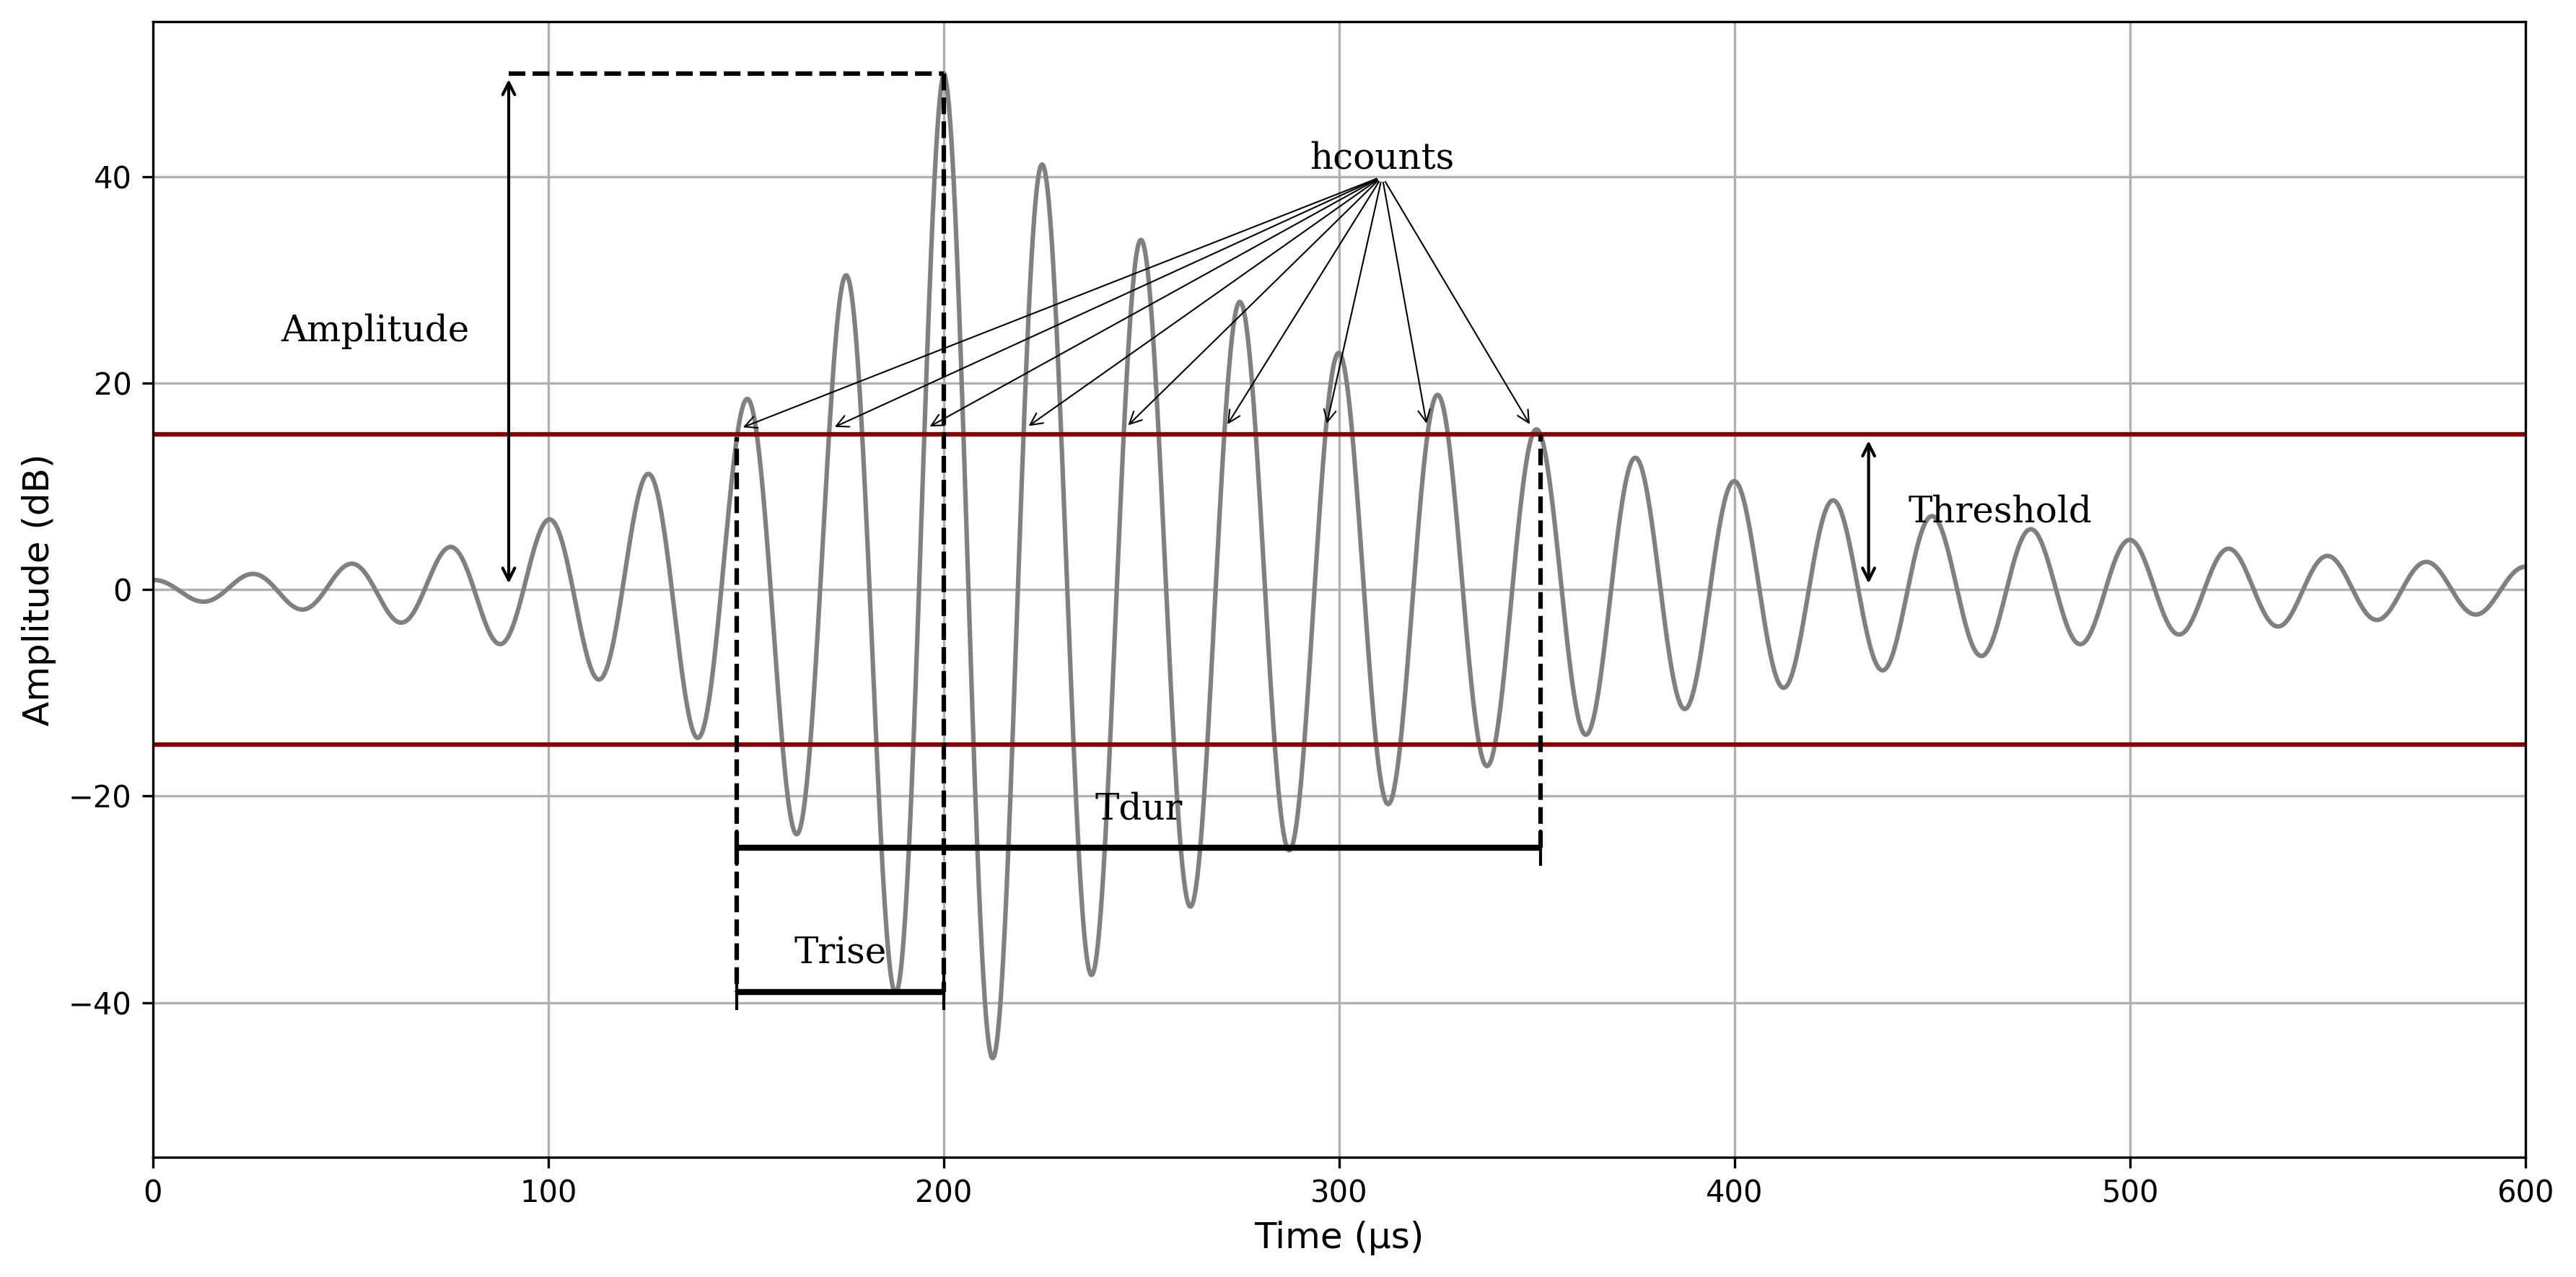

Имеется 15 признаков и 1 целевая переменная – Clust или индекс группы. В ходе предварительной обработки с помощью взаимнокорреляционного метода было выявлено 3 группы импульсов (1, 2, 3 соответственно), остальные импульсы отнесены к классу 0. Таким образом, к классу 0 принадлежат те импульсы, которые имеют уникальные волновые формы и поэтому могут быть отнесены к группе фонового шума, состоящему из импульсов от многочисленных микротрещин и частично из помеховых импульсов.

Описание столбцов датасета:

(**NB**: Некоторые величины являются производными от других)

1. `Time`	--	Время регистрации импульса с начала эксперимента (превышения сигналом порогового уровня), с

2. `Aadc`	--	Амплитуда (максимальная) импульса, в единицах АЦП

3. `AdB`		--	Амплитуда -//-, в децибеллах (дБ) относительно 1 мкВ. Определяется через `AuV`, как: $A_\text{dB} = 20 \cdot \lg(A_\text{uV}/\text{1 мкв})$.

4. `AuV`		--	Амплитуда -//-, мкВ. Определяется через `Aadc`, как:
$A_\text{uV} = A_\text{adc} \cdot LSB$, где `LSB` -- величина младшего значащего разряда АЦП в мкВ.

5. `A2hcounts`	-- `AuV`/`hcounts`, мкВ

6. `LnA2hcounts`	-- $\ln($ `AuV`/`hcounts` $)$

7. `EioktoJ`	--	Энергия импульса, иДж (иоктоджоуль или $10^{-24}$ Дж) (определяется через сумму квадратов нескольких первых амплитуд импульса)

8. `EdB`		--	Энергия, дБ (относительно $10^{-24}$ Дж)

9. `Emarse`	--	Энергия, MARSE (оценка, близкая к площади кривой под графиком сигнала)

10. `Tdur`	--	Длительность импульса, мкс

11. `Trise`	--	Время нарастания импульса, мкс

12. `hcounts`	--	Количество выбросов (превышений порога регистрации за длительность импульса)

13. `AF`	--		`hcounts`/`Tdur` (эквивалентно "средней" частоте импульса -- "Average frequency"), кГц

14. `RA`	--		`Trise`/`AuV` (обратно пропорционально скорости нарастания импульса), с/В

15. `Clust`	--	№ кластера (номер кластера 1--3, определенного в результате корреляции волновых форм друг с другом; 0 -- остальные импульсы)

16. `Heat`	--	нагрев/охлаждение (1 -- нагрев, 0 -- охлаждение)


## Загрузка датасета

Из датасета сразу исключаются мпульсы, относящиеся к типичным помехам в соответствии с условиями, налагаемыми на среднюю частоту `AF` и амплитудно-временной параметр сигнала `RA`:

$50 < AF < 550$ кГц,

$1 < RA < 100$ В/с.

In [344]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import requests

In [345]:
url = "https://raw.githubusercontent.com/Gutleyb/MSU.AI-Sandstone_ML/refs/heads/main/sandstone_data.csv" # ссылка на GitHub
dataset_in = pd.read_csv(url, decimal=',')
dataset_in = dataset_in.apply(pd.to_numeric)

# фильтрация помеховых импульсов

df = dataset_in.copy()
df = df.where((df['AF']>50) & (df['AF']<550) &
              (df['RA']>1) & (df['RA']<100)).dropna()
# df['Scale'] = np.sqrt(df['Emarse'] * df['Tdur'] / (df['Emarse'].max() * df['Tdur'].max())) # свой признак масштаба
df = df.drop(columns=['Aadc']) # Линейная связь с AuV
df['Clust'] = df['Clust'].astype(int)
print(df.head())

       Time   AdB   AuV  A2hcounts  LnA2hcounts   EioktoJ   EdB    Emarse  \
0   230.456  36.8  69.4        6.9      0.05465  162861.0  52.1  403560.5   
3   923.214  37.3  73.1        8.1      0.06643  106406.0  50.3  326199.9   
5  1821.328  36.0  63.3       12.7      0.09095   87070.0  49.4  295076.0   
6  3980.934  33.8  48.7       24.4      0.09619   14664.0  41.7  121096.0   
7  3999.754  34.8  54.8       18.3      0.10338   51946.0  47.2  227916.5   

   Tdur  Trise  hcounts     AF      RA  Clust  Heat  
0  57.0   35.0     10.0  175.0   1.983      0   1.0  
3  41.0    5.0      9.0  219.0  14.620      0   1.0  
5  29.0    1.0      5.0  172.0  63.300      0   1.0  
6   7.0    7.0      2.0  285.0   6.957      0   1.0  
7  25.0   13.0      3.0  120.0   4.215      0   1.0  


В общем случае нормализация признаков перед применением некоторых методов ML является рекомендуемой процедурой. Однако нормализация не влияет на работу алгоритмов, связанных с деревьями решений, а также не критична для LDA для данного датасета, что подтверждается эмпирической проверкой. Последнее может быть обусловлено тем, что признаки имеют сопоставимые масштабы, ковариационная структура данных не нарушена, и отсутствуют доминирующие переменные, способные исказить дискриминантное пространство. Поэтому алгоритм LDA способен эффективно извлекать линейные комбинации, разделяющие классы, без предварительной нормализации данных.

(см. https://www.casact.org/sites/default/files/2022-12/James-G.-et-al.-2nd-edition-Springer-2021.pdf)

In [343]:
# from sklearn.preprocessing import RobustScaler
# df_scaled = df.copy()
# scaler = RobustScaler()
# df_scaled[features] = scaler.fit_transform(df.drop(columns=['Clust']))
# df_scaled['Clust'] = df['Clust'].values

Посмотрим на распределение данных в датасете и на корреляцию признаков.

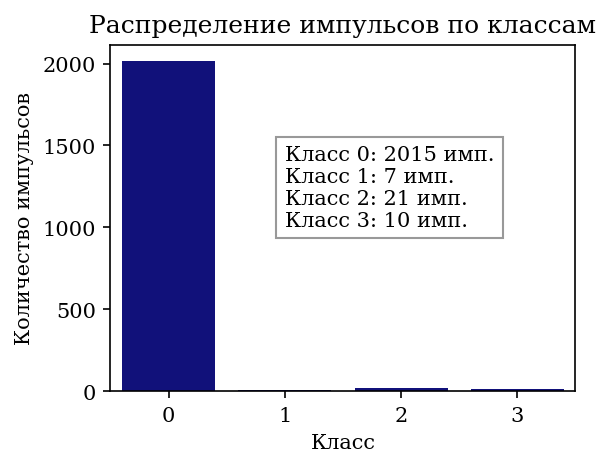

In [346]:
def bar_chart(y, title='Распределение импульсов по классам'):
    plt.figure(figsize=(4, 3), dpi=150)
    plt.rcParams["font.family"] = "DejaVu Serif"
    sns.countplot(x=y, color='darkblue', legend=False)
    plt.text(1, df[df.Clust == 0].shape[0]*0.5,
             f'Класс {0}: {df[df.Clust == 0].shape[0]} имп.\nКласс {1}: {df[df.Clust == 1].shape[0]} имп.\nКласс {2}: {df[df.Clust == 2].shape[0]} имп.\nКласс {3}: {df[df.Clust == 3].shape[0]} имп.',
             color='k', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    plt.xlabel("Класс")
    plt.ylabel("Количество импульсов")
    plt.title(title)
    plt.show()
bar_chart(df['Clust'])

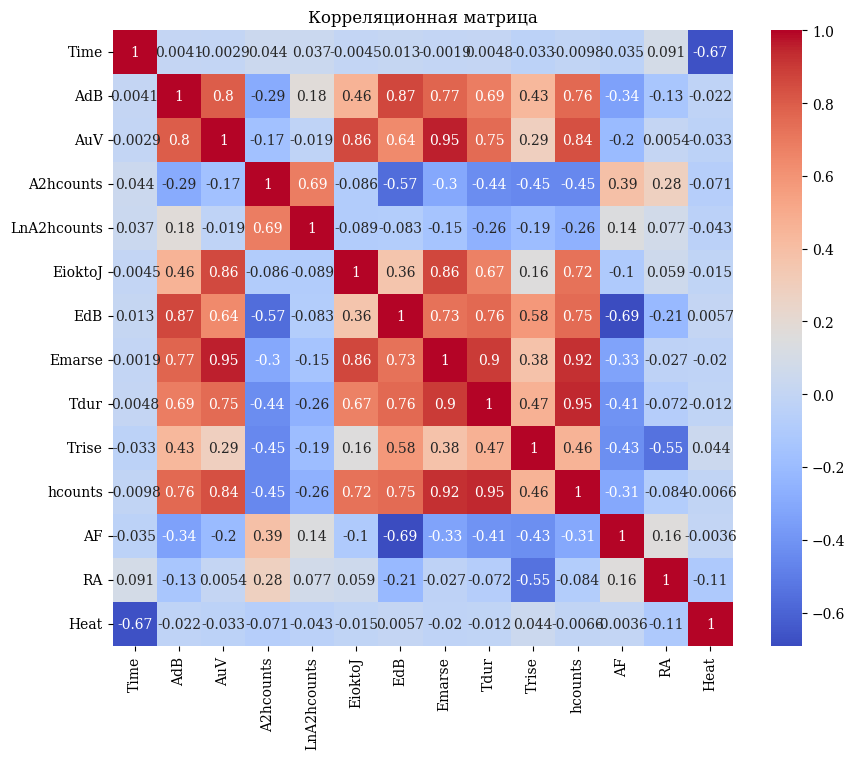

In [460]:
corr_matrix = df.drop(columns=['Clust']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица")
plt.show()

Таким образом, в распределении событий по классам датасет является существенно несбалансированным. Также некоторые признаки показывают высокую корреляцию друг с другом. Тем не менее, из-за недостатка данных и слабой чувствительности моделей деревьев к скоррелированным признакам оставим большинство признаков. Корреляция между некоторыми из них может отражать характеристику волновой формы, так как по физической смыслу коррелирующие признаки могут быть принципиально различны, как, например, `Tdur` и `hcounts`.

# Дисперсионный анализ

Проверим, что классы статистически различимы между собой. Исследуем совокупность признаков с помощью многомерного дисперсионного анализа (MANOVA), затем оценим распределение классов по каждому признаку с помощью одномерного дисперсионного анализа (ANOVA) и уточним, как различаются классы попарно при помощи теста Тьюки. Визуализируем распределение данных по классам в пространстве признаков с помощью LDA.

## MANOVA (Multivariate Analysis of Variance)

In [353]:
from statsmodels.multivariate.manova import MANOVA

manova = MANOVA.from_formula(' + '.join([col for col in df.columns if col != 'Clust']) + ' ~ Clust', data=df)
print(manova.mv_test())

                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
       Intercept          Value    Num DF   Den DF    F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambda    0.0005 13.0000 2039.0000 339366.3492 0.0000
         Pillai's trace    0.9995 13.0000 2039.0000 339366.3492 0.0000
 Hotelling-Lawley trace 2163.6893 13.0000 2039.0000 339366.3492 0.0000
    Roy's greatest root 2163.6893 13.0000 2039.0000 339366.3492 0.0000
----------------------------------------------------------------------
                                                                      
-----------------------------------------------------------------------
            Clust           Value    Num DF    Den DF   F Value  Pr > F
-----------------------------------------------------------------------
             Wilks' lambda

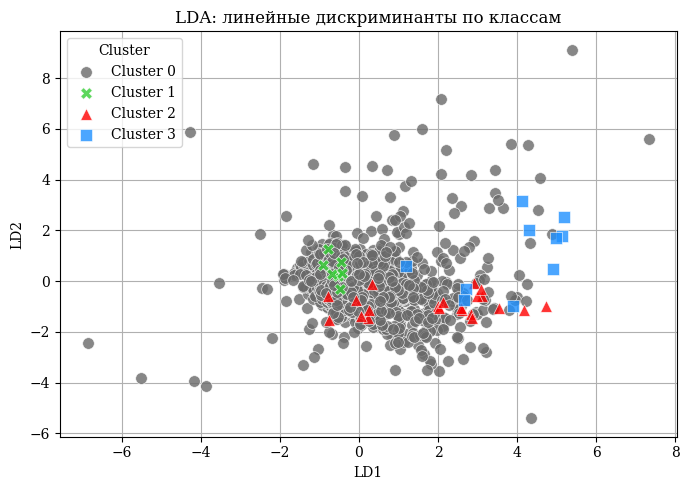

In [360]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = df.drop(columns='Clust')
y = df['Clust']

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)

lda_df = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
lda_df['Clust'] = y.values

import matplotlib.pyplot as plt
import seaborn as sns

style_map = {
    0: {'color': 'dimgray', 'marker': 'o'},  # кружок
    1: {'color': 'limegreen', 'marker': 'X'},  # крест
    2: {'color': 'red', 'marker': '^'},  # треугольник вверх
    3: {'color': 'dodgerblue', 'marker': 's'},  # квадрат
}

draw_order = [0, 1, 2, 3] # Порядок отрисовки: 0 внизу, 3 поверх

plt.figure(figsize=(7, 5))

for clust in draw_order:
    subset = lda_df[lda_df['Clust'] == clust]
    sns.scatterplot(
        data=subset,
        x='LD1',
        y='LD2',
        color=style_map[clust]['color'],
        marker=style_map[clust]['marker'],
        label=f'Cluster {clust}',
        s=70,
        edgecolor='white',
        linewidth=0.5,
        alpha = 0.8,
        zorder=2
    )

plt.title('LDA: линейные дискриминанты по классам')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.grid(True, zorder=0)
plt.show()

Было проанализировано влияние номера класса на вектор из 13 зависимых переменных, что меньше на 1 признак из содержащихся в датасете из-за высокой скоррелированности некоторых признаков. Анализировались четыре тестовых критерия: `Wilks’ lambda`, `Pillai’s trace`, `Hotelling–Lawley trace` и `Roy’s greatest root`. Каждый из них оценивает гипотезу о равенстве векторных средних во всех группах, определяемых номером класса. Результаты показывают, что классы статистически различимы: номер класса импульса оказывает статистически значимое влияние на многомерный профиль признаков. Тем не менее, доля объяснённой дисперсии в критериях, используемых MANOVA, составляет менее 10%, что указывает на умеренную силу различий между классами.

(см. https://ostad.hormozgan.ac.ir/ostad/UploadedFiles/863845/97050509-3761826667770356.pdf,

https://ru.statisticseasily.com/manova/)

Визуализация распределения импульсов в признаковом пространстве с учетом классов, выполненная с применением LDA, показывает, что импульсы класса 3 расположены

## ANOVA (Analysis of Variance)

In [356]:
from scipy.stats import f_oneway

features = df.columns.drop('Clust')
results = []

for feature in features:
    groups = [df[df['Clust'] == label][feature] for label in sorted(df['Clust'].unique())]

    # one-way ANOVA
    f_val, p_val = f_oneway(*groups)

    results.append({
        'Feature': feature,
        'F-statistic': f_val,
        'p-value': p_val
    })

anova_df = pd.DataFrame(results)
anova_df = anova_df.sort_values(by='p-value')  # отсортируем по убыванию
significant_features = anova_df[anova_df['p-value'] < 0.05] # покажем только p < 0.05

print('Значимые признаки (p < 0.05):')
print(significant_features)

Значимые признаки (p < 0.05):
      Feature  F-statistic       p-value
1         AdB    28.998149  2.328810e-18
6         EdB    22.181315  3.916854e-14
2         AuV     8.808881  8.397113e-06
10    hcounts     7.865258  3.227688e-05
7      Emarse     7.677510  4.217311e-05
9       Trise     5.860930  5.544647e-04
3   A2hcounts     5.727658  6.691195e-04
11         AF     3.554993  1.384120e-02
8        Tdur     3.064379  2.705472e-02
13       Heat     2.655802  4.697426e-02


Так как параметры `AF`, `Tdur` и `Heat` имеет значения p-value порядка пограничного и сильно больше остальных, исключим их из `significant_features` и отобразим распределение значений признаков по классам.

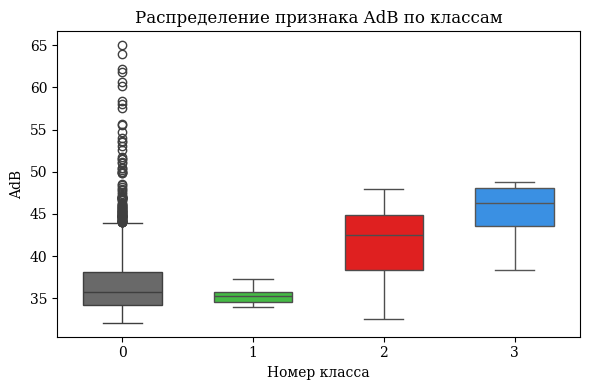

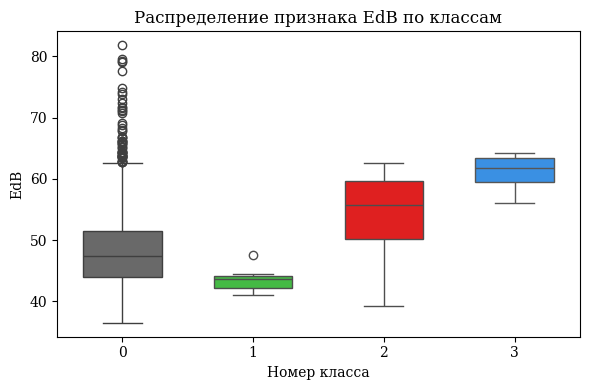

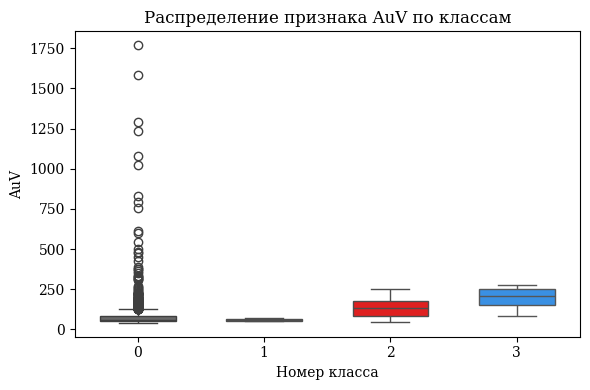

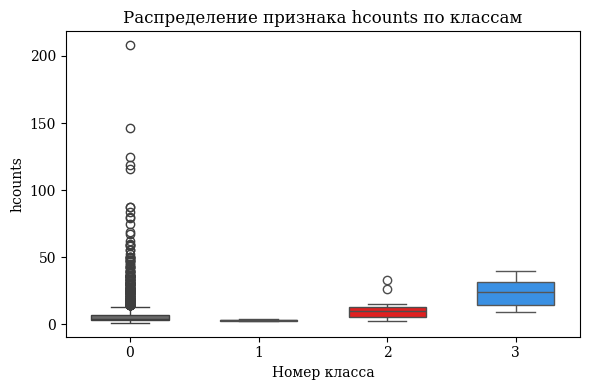

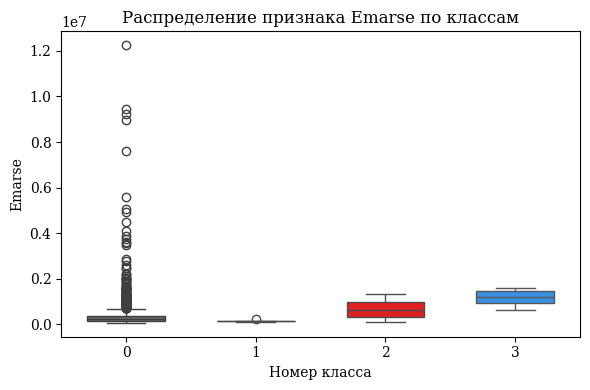

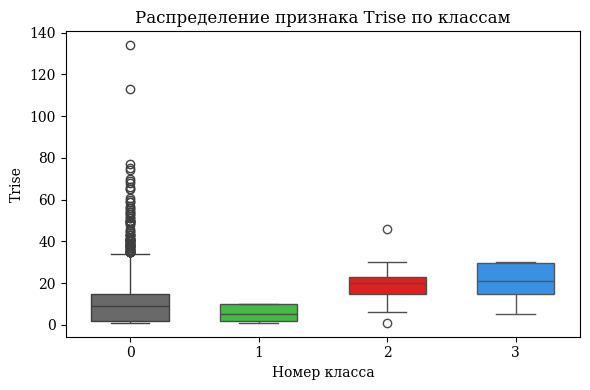

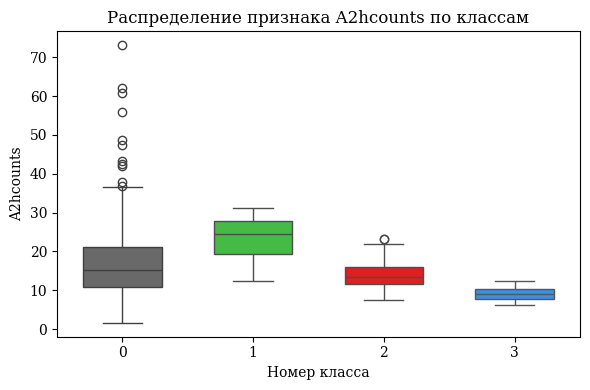

In [461]:
for feature in list(significant_features['Feature'].values[:-3]):
    plt.figure(figsize=(6, 4))

    for clust in sorted(df['Clust'].unique()):
        sns.boxplot(
            data=df[df['Clust'] == clust],
            x='Clust',
            y=feature,
            color=style_map[clust]['color'],
            width=0.6
        )
    plt.title(f'Распределение признака {feature} по классам')
    plt.xlabel('Номер класса')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

ANOVA подтверждает выводы MANOVA: из 14 проанализированных признаков, 10 оказались статистически значимыми при уровне значимости 0.05. Несмотря на то, что различия между классами 1--3 могут быть выражены неярко, эти классы существенно отличимы от фонового класса 0, что особенно заметно для класса 3.

## Tukey's HSD (honestly significant difference) test


Tukey HSD for feature: AdB
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -1.3343 0.7916 -5.0439  2.3754  False
     0      2   4.8038    0.0  2.6547   6.953   True
     0      3   8.8429    0.0  5.7369 11.9489   True
     1      2   6.1381 0.0013   1.862 10.4142   True
     1      3  10.1771    0.0  5.3488 15.0055   True
     2      3    4.039 0.0298  0.2746  7.8035   True
----------------------------------------------------


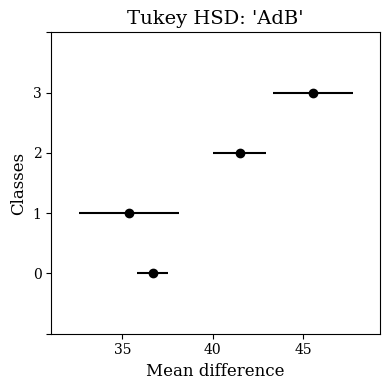


Tukey HSD for feature: EdB
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -4.7939 0.1759 -10.8545  1.2667  False
     0      2   6.1632    0.0    2.652  9.6744   True
     0      3  12.8261    0.0   7.7516 17.9005   True
     1      2  10.9571 0.0003   3.9711 17.9432   True
     1      3    17.62    0.0   9.7316 25.5084   True
     2      3   6.6629 0.0276   0.5128  12.813   True
-----------------------------------------------------


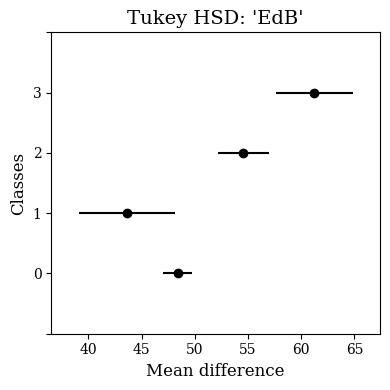


Tukey HSD for feature: AuV
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1 -20.4832 0.9283 -106.5479  65.5816  False
     0      2  53.7406 0.0288    3.8794 103.6019   True
     0      3 120.5425 0.0001   48.4822 192.6029   True
     1      2  74.2238 0.2184  -24.9831 173.4307  False
     1      3 141.0257 0.0067   29.0054  253.046   True
     2      3  66.8019  0.201  -20.5339 154.1378  False
-------------------------------------------------------


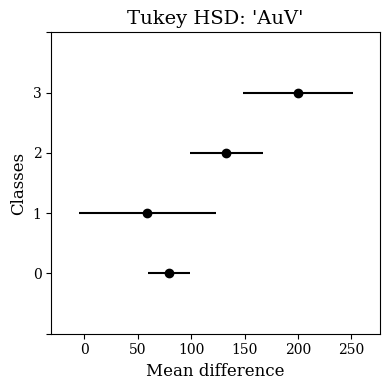


Tukey HSD for feature: hcounts
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -4.519 0.7187 -15.563  6.5251  False
     0      2   3.5763 0.4762  -2.822  9.9746  False
     0      3  16.2667    0.0  7.0198 25.5137   True
     1      2   8.0952 0.3591 -4.6352 20.8257  False
     1      3  20.7857 0.0012   6.411 35.1604   True
     2      3  12.6905  0.019  1.4833 23.8976   True
----------------------------------------------------


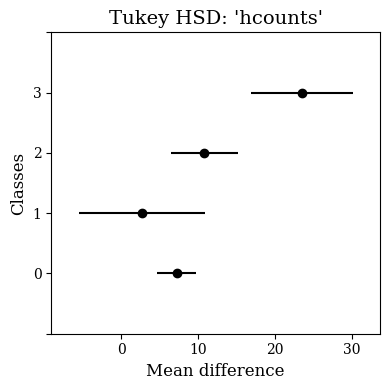


Tukey HSD for feature: Emarse
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------
     0      1  -221377.058 0.7816 -824967.6123  382213.4962  False
     0      2  301481.8563  0.119  -48205.6521  651169.3646  False
     0      3  817591.6634 0.0002   312217.084 1322966.2428   True
     1      2  522858.9143 0.2148 -172899.9572 1218617.7858  False
     1      3 1038968.7214 0.0038  253346.3444 1824591.0985   True
     2      3  516109.8071  0.133  -96395.1444 1128614.7587  False
------------------------------------------------------------------


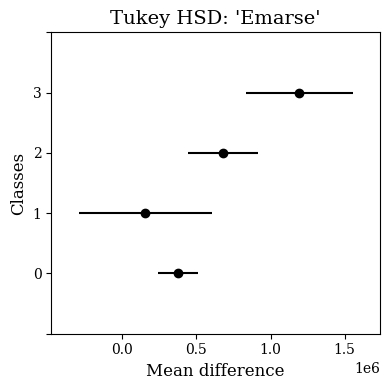


Tukey HSD for feature: Trise
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -5.7056 0.5579 -16.9213  5.5102  False
     0      2   7.5325 0.0154   1.0347 14.0303   True
     0      3   9.6801 0.0404   0.2894 19.0709   True
     1      2  13.2381 0.0424   0.3097 26.1665   True
     1      3  15.3857 0.0343   0.7875  29.984   True
     2      3   2.1476 0.9624  -9.2338  13.529  False
-----------------------------------------------------


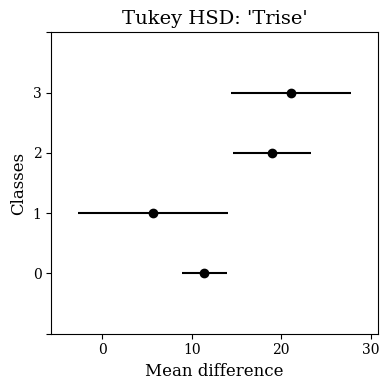


Tukey HSD for feature: A2hcounts
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1   7.1039 0.0455   0.0964 14.1115   True
     0      2  -1.6484 0.7235  -5.7082  2.4114  False
     0      3  -6.9389 0.0128 -12.8062 -1.0716   True
     1      2  -8.7524 0.0276   -16.83 -0.6748   True
     1      3 -14.0429 0.0005 -23.1638 -4.9219   True
     2      3  -5.2905 0.2229 -12.4015  1.8206  False
-----------------------------------------------------


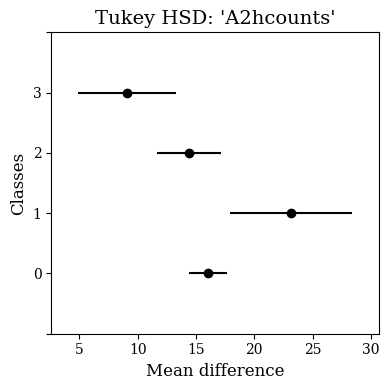

In [366]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for feature in list(significant_features['Feature'].values[:-3]):
    tukey = pairwise_tukeyhsd(endog=df[feature], groups=df['Clust'], alpha=0.05)
    print(f"\nTukey HSD for feature: {feature}")
    print(tukey.summary())
    tukey.plot_simultaneous()
    fig = plt.gcf()
    fig.set_size_inches(4, 4)
    plt.title(f"Tukey HSD: '{feature}'", fontsize=14)
    plt.xlabel("Средняя разность", fontsize=12)
    plt.ylabel("Номер класса", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

Результаты парных сравнений признаков по тесту Тьюки показывают, что распределение признаков между классами неоднородно и имеет четко выраженную иерархию отличий. Для большинства признаков есть уверенное различие между классами 0 и 2, 0 и 3, 1 и 2, 1 и 3. При этом между классами 0 и 1 по большинству признаков значимых различий не наблюдается (`AdB`, `EdB`, `AuV`, `hcounts`, `Emarse`, `Trise`), а класс 3, как правило, отличается от всех остальных классов по большинству признаков с высокой статистической значимостью.

(о тесте Тьюки см. http://repo.darmajaya.ac.id/5678/1/Discovering%20Statistics%20Using%20IBM%20SPSS%20Statistics%20%28%20PDFDrive%20%29.pdf)

Таким образом, классы 0 и 1 могут рассматриваться как близкие или смежные группы, а классы 2 и 3 -- как более отчётливо отделённые. Следует ожидать, что при классификации классы 2 и 3 будут легче определяться, причем класс 3 лучше прочих.

# I. Задача классификации

## Разделение на train/test

В данном разделе применяются различные классификационные методы ML.

Сперва разделим датасет на обучающую и тестовую выборки. Для обеспечения разумного числа импульсов в тестовой выборке проведем разделение в соотношении:

65% - trainset / 35% - testset.

Значений в минорных классах недостаточно для обучения моделей, поэтому необходимо провести аугментацию данных. Так как параметры имеют определенные связи друг с другом, искусственная аугментация с добавлением гауссового шума к значению параметра может быть физически необоснованной. Использование GAN-based Oversampling представляется избыточным решением, так как число объектов в минорных классах ограничено 10-20 импульсами. Использование SMOTE может быть сопряжено с генерацией нереалистичных данных, особенно если они имеют нелинейную структуру. Тем не менее, SMOTE подразумевает интерполяцию между ближайшими соседями в пространстве признаков, что можно интерпретировать как добавление таких импульсов, параметры которых сохраняют общий характер взаимных зависимостей.

(см. https://www.jair.org/index.php/jair/article/view/10302 - SMOTE,

https://www.sciencedirect.com/science/article/abs/pii/S0952197624000927 - GAN-based Oversampling)

Исходя из сказанного, наиболее подходящим методом балансировки данных был выбран SMOTE.

In [372]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [374]:
sampler_type = 'smote'
def make_set(df, sampler_type=sampler_type, colname='Clust'): # smote / undersampling / oversampling / my -
    x = df.drop(columns=[colname]) # .values or .to_numpy() для np array
    y = df[colname].astype(int)
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.65, test_size=0.35, stratify=y, random_state=42) # 65 / 35

    if sampler_type == 'smote':
        class_counts = y_train.value_counts()
        coef = 1
        sampling_strategy = {
            0: class_counts[0],
            1: int(class_counts[0] * coef),
            2: int(class_counts[0] * coef),
            3: int(class_counts[0] * coef)
        }

        smote = SMOTE(k_neighbors=4, sampling_strategy=sampling_strategy, random_state=42)
        x_train, y_train = smote.fit_resample(x_train, y_train)
    elif sampler_type == 'undersampling':
        undersampling = RandomUnderSampler(random_state=42)
        x_train, y_train = undersampling.fit_resample(x_train, y_train)
    elif sampler_type == 'oversampling':
        oversampling = RandomOverSampler(random_state=42)
        x_train, y_train = oversampling.fit_resample(x_train, y_train)
    elif sampler_type == 'my':
        error_level = 0.01  # 1% noise
        majority_class = 0
        modifiable_features = df.columns

        # Ensure x_train is a DataFrame and y_train is a Series or np.array
        x_train_aug = x_train.copy()
        y_train_aug = y_train.copy()

        # Determine max class size (i.e., class 0 size)
        class_counts = y_train.value_counts() if isinstance(y_train, pd.Series) else pd.Series(y_train).value_counts()
        max_class_size = class_counts[majority_class]

        for c in [1, 2, 3]:
            minority_samples = x_train[y_train == c]
            minority_size = len(minority_samples)
            n_to_generate = max_class_size - minority_size

            if n_to_generate <= 0:
                continue

            indices = np.random.choice(minority_size, size=n_to_generate, replace=True)
            samples_to_augment = minority_samples.iloc[indices].copy()

            noise = np.random.normal(loc=0.0, scale=error_level, size=(n_to_generate, len(modifiable_features)))
            samples_to_augment[modifiable_features] *= (1 + noise)

            synthetic_labels = np.full(n_to_generate, c)
            x_train_aug = pd.concat([x_train_aug, samples_to_augment], axis=0)
            y_train_aug = np.concatenate([y_train_aug, synthetic_labels])

        y_train = y_train_aug
        x_train = x_train_aug

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = make_set(df, sampler_type=sampler_type)

Распределение классов в тренировочной выборке по числу импульсов и в пространстве признаков (LDA):

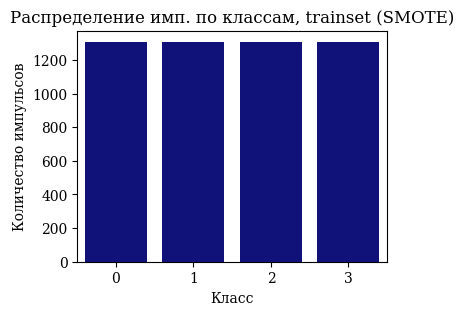

In [376]:
plt.figure(figsize=(4, 3)) # dpi=600 to increase the quality
sns.countplot(x=y_train, color='darkblue', legend=False)
plt.xlabel("Класс")
plt.ylabel("Количество импульсов")
plt.title('Распределение имп. по классам, trainset (SMOTE)')
plt.show()

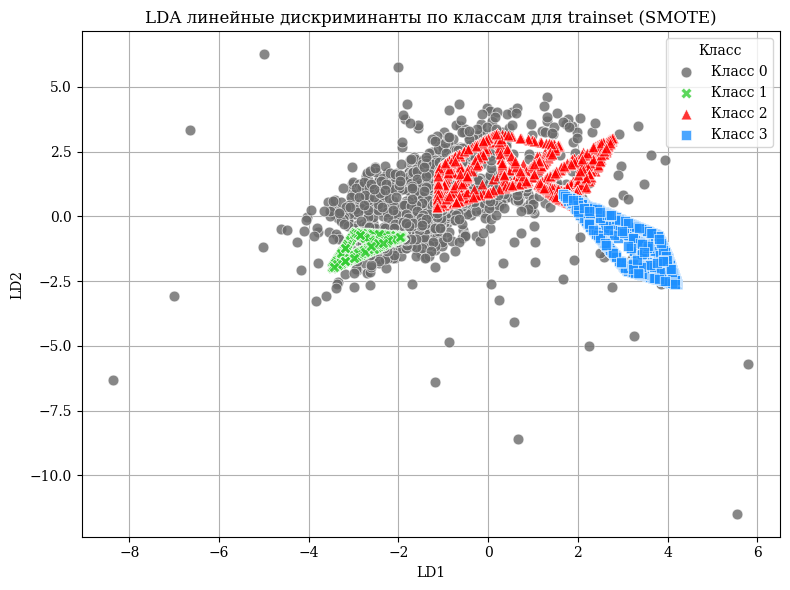

In [381]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
x_lda = lda.fit_transform(x_train, y_train)

lda_df = pd.DataFrame()
lda_df['LDA1'] = x_lda[:, 0]
lda_df['LDA2'] = x_lda[:, 1]
lda_df['Class'] = y_train.values if hasattr(y_train, 'values') else y_train


plt.figure(figsize=(8, 6))

for cls, style in style_map.items():
    subset = lda_df[lda_df['Class'] == cls]
    plt.scatter(
        subset['LDA1'], subset['LDA2'],
        c=style['color'],
        marker=style['marker'],
        label=f'Класс {cls}',
        s=60,
        alpha=0.8,
        edgecolors='white',
        linewidths=0.5,
        zorder=2
    )

plt.title("LDA линейные дискриминанты по классам для trainset (SMOTE)")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend(title='Класс', loc='best')
plt.grid(True, zorder=0)
plt.tight_layout()
plt.show()

## 1) AdaBoost

In [385]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [393]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
!pip install -q optuna

import optuna

In [397]:
def objective(trial):
    # hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 3)

    base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    score = cross_val_score(model, x_train, y_train, cv=5, scoring="recall_weighted").mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-01 19:57:48,829] A new study created in memory with name: no-name-1ce23bc9-303a-43f4-bb29-75f84e2ae78d
[I 2025-06-01 19:58:07,154] Trial 0 finished with value: 0.9073738489468273 and parameters: {'n_estimators': 291, 'learning_rate': 0.6003091987097011, 'max_depth': 1}. Best is trial 0 with value: 0.9073738489468273.
[I 2025-06-01 19:58:24,237] Trial 1 finished with value: 0.8017578395561291 and parameters: {'n_estimators': 281, 'learning_rate': 0.05690347881552833, 'max_depth': 1}. Best is trial 0 with value: 0.9073738489468273.
[I 2025-06-01 19:58:52,270] Trial 2 finished with value: 0.9344938646952032 and parameters: {'n_estimators': 269, 'learning_rate': 0.15306847922246253, 'max_depth': 2}. Best is trial 2 with value: 0.9344938646952032.
[I 2025-06-01 19:59:05,184] Trial 3 finished with value: 0.7836145803713992 and parameters: {'n_estimators': 210, 'learning_rate': 0.0419316017556743, 'max_depth': 1}. Best is trial 2 with value: 0.9344938646952032.
[I 2025-06-01 19:59:

Best trial:
  Accuracy: 0.9931
  Params:
    n_estimators: 204
    learning_rate: 0.9953305976094386
    max_depth: 3


In [407]:
# best_params =
'''
Best trial:
  Accuracy: 0.9931
  Params:
    n_estimators: 204
    learning_rate: 0.9953305976094386
    max_depth: 3
'''

best_params = study.best_params
best_base_estimator = DecisionTreeClassifier(max_depth=best_params["max_depth"], random_state=42)

model_best_ada = AdaBoostClassifier(
    estimator=best_base_estimator,
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    random_state=42
)

model_best_ada.fit(x_train, y_train)

y_pred = model_best_ada.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       706
           1       0.00      0.00      0.00         2
           2       0.12      0.14      0.13         7
           3       0.33      0.50      0.40         4

    accuracy                           0.97       719
   macro avg       0.36      0.41      0.38       719
weighted avg       0.97      0.97      0.97       719



In [414]:
def matrix_plot(model, name='test'):
    y_test_int = y_test.astype(int)
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test_int, cmap="Blues", values_format='d')
    plt.title(name + ": Матрица несоответствий")
    plt.ylabel('Истинный кластер')
    plt.xlabel('Предсказанный кластер')
    #plt.savefig(name + "cm.pdf", bbox_inches='tight')
    plt.show()

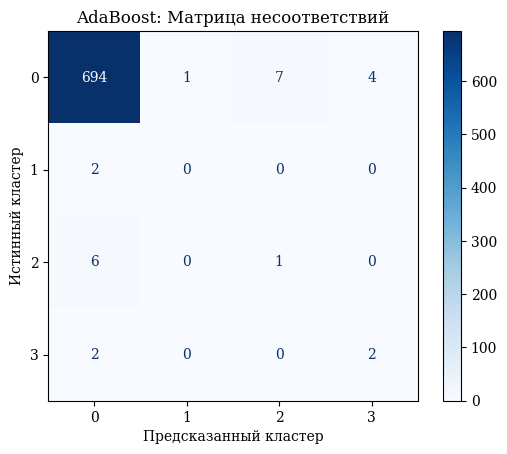

In [415]:
matrix_plot(model_best_ada, name='AdaBoost')

In [412]:
def importance_plot(model, name='test'):
    feat_imp_df = pd.DataFrame({
        "Feature": x_train.columns,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(6, 5))
    sns.barplot(x="Importance", y="Feature", data=feat_imp_df, color='#2c6fbb')
    plt.title(name + ": важность признаков")
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.xlabel('Важность (вклад) признака')
    #plt.savefig(name+"fi.pdf", bbox_inches='tight')
    plt.show()

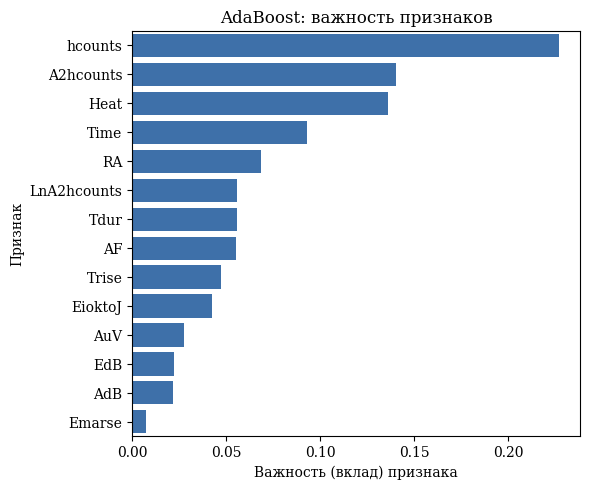

In [413]:
importance_plot(model_best_ada, name='AdaBoost')

## 2) Random Forest

In [409]:
from sklearn.ensemble import RandomForestClassifier

In [420]:
def objective(trial):
    # hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(recall_score, average='weighted')  # или 'macro'
    recall_scores = cross_val_score(model, x_train, y_train, cv=kf, scoring=scorer)

    return recall_scores.mean()

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"  Recall: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-01 20:33:55,930] A new study created in memory with name: no-name-926d6da6-e6d6-49e1-8656-5c25b67e29e5
[I 2025-06-01 20:34:14,029] Trial 0 finished with value: 0.9906404704098222 and parameters: {'n_estimators': 281, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.9906404704098222.
[I 2025-06-01 20:34:17,054] Trial 1 finished with value: 0.7494296681904679 and parameters: {'n_estimators': 60, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.9906404704098222.
[I 2025-06-01 20:34:18,306] Trial 2 finished with value: 0.7939264857061615 and parameters: {'n_estimators': 56, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.9906404704098222.
[I 2025-06-01 20:34:58,066] Trial 3 finished with value: 0.98834984725533

Best trial:
  Recall: 0.9910225143448749
  Params:
    n_estimators: 229
    max_depth: 20
    min_samples_split: 8
    min_samples_leaf: 1
    max_features: sqrt
    criterion: entropy


In [426]:
'''
Best trial:
  Recall: 0.9910225143448749
  Params:
    n_estimators: 229
    max_depth: 20
    min_samples_split: 8
    min_samples_leaf: 1
    max_features: sqrt
    criterion: entropy
'''

best_params = study.best_params

model_best_rf = RandomForestClassifier(
    **best_params
)

model_best_rf.fit(x_train, y_train)

y_pred = model_best_rf.predict(x_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      0.987     0.987     0.987       706
           1      0.000     0.000     0.000         2
           2      0.250     0.286     0.267         7
           3      0.400     0.500     0.444         4

    accuracy                          0.975       719
   macro avg      0.409     0.443     0.425       719
weighted avg      0.974     0.975     0.974       719



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


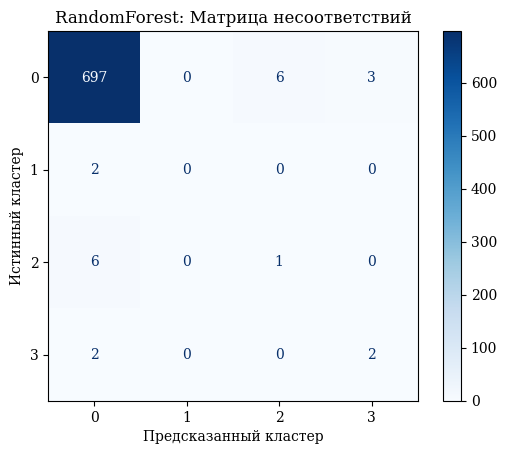

In [422]:
matrix_plot(model_best_rf, name='RandomForest')

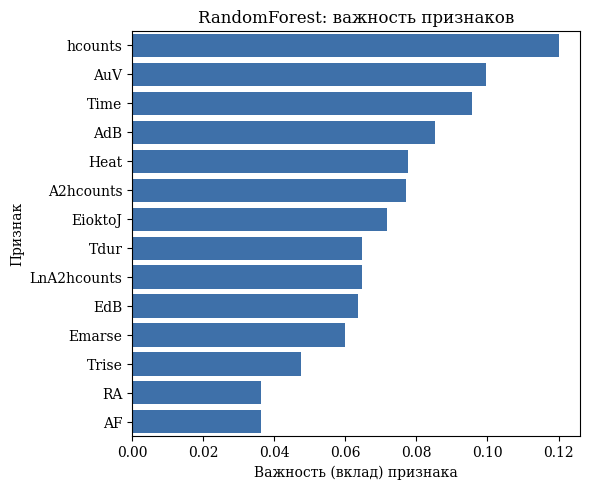

In [423]:
importance_plot(model_best_rf, name='RandomForest')

## 3) XGBoost

In [425]:
import xgboost as xgb
from xgboost import plot_importance

In [427]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 0, 5),
    }

    model_xgb = xgb.XGBClassifier(**params, random_state=42)
    scores = cross_val_score(model_xgb, x_train, y_train, cv=30, scoring=make_scorer(recall_score, average='weighted'))

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best Hyperparameters:", study.best_params)

[I 2025-06-01 20:44:17,321] A new study created in memory with name: no-name-6899c2e0-3b77-4c97-81c4-87b0d218a227
[I 2025-06-01 20:44:50,434] Trial 0 finished with value: 0.9810914066776135 and parameters: {'n_estimators': 192, 'max_depth': 6, 'learning_rate': 0.020010714443363737, 'subsample': 0.9824466377796146, 'colsample_bytree': 0.5205216567377972, 'gamma': 3.046867137476377, 'lambda': 0.18805163749964604}. Best is trial 0 with value: 0.9810914066776135.
[I 2025-06-01 20:45:24,342] Trial 1 finished with value: 0.9723087027914613 and parameters: {'n_estimators': 221, 'max_depth': 4, 'learning_rate': 0.024855722778343827, 'subsample': 0.8176278638768468, 'colsample_bytree': 0.9017601419771908, 'gamma': 4.362963185618913, 'lambda': 4.047728100479249}. Best is trial 0 with value: 0.9810914066776135.
[I 2025-06-01 20:46:34,406] Trial 2 finished with value: 0.9873935413245758 and parameters: {'n_estimators': 439, 'max_depth': 4, 'learning_rate': 0.018955545973030157, 'subsample': 0.7741

Best Hyperparameters: {'n_estimators': 465, 'max_depth': 7, 'learning_rate': 0.08548160573047646, 'subsample': 0.713955065724356, 'colsample_bytree': 0.5776420822641618, 'gamma': 0.011313413762405331, 'lambda': 4.216076918218162}


In [428]:
'''
Best Hyperparameters: {'n_estimators': 465,
                       'max_depth': 7,
                       'learning_rate': 0.08548160573047646,
                       'subsample': 0.713955065724356,
                       'colsample_bytree': 0.5776420822641618,
                       'gamma': 0.011313413762405331,
                       'lambda': 4.216076918218162}
'''

best_params = study.best_params
model_xgb_best = xgb.XGBClassifier(**best_params, random_state=42)
model_xgb_best.fit(x_train, y_train)

y_pred = model_xgb_best.predict(x_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       706
           1       0.00      0.00      0.00         2
           2       0.38      0.43      0.40         7
           3       0.43      0.75      0.55         4

    accuracy                           0.98       719
   macro avg       0.45      0.54      0.48       719
weighted avg       0.98      0.98      0.98       719



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


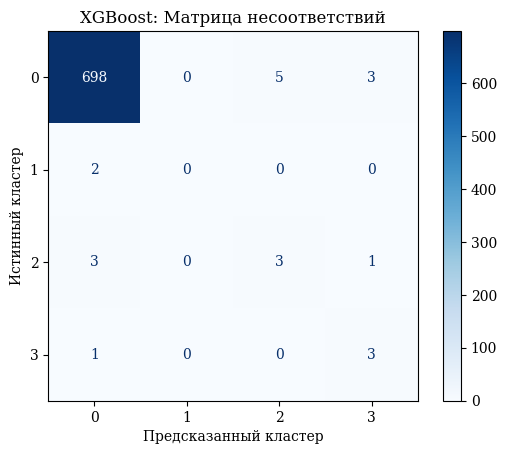

In [429]:
matrix_plot(model_xgb_best, name='XGBoost')

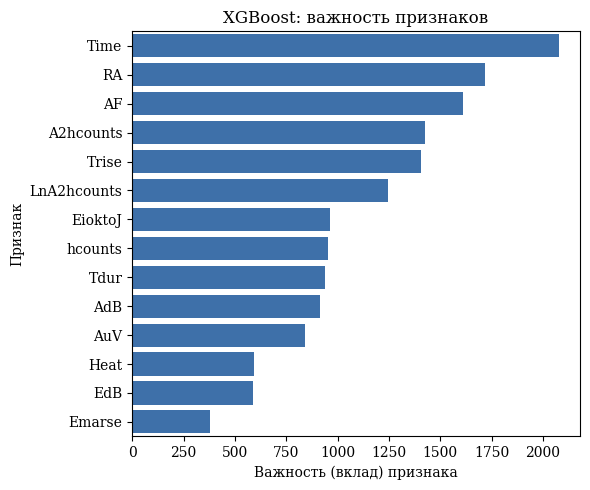

In [430]:
booster = model_xgb_best.get_booster()
importance_dict = booster.get_score(importance_type='weight')  # или 'gain', 'cover'

feat_imp_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

name = 'XGBoost'
plt.figure(figsize=(6, 5))
plt.title(name + ": важность признаков")
sns.barplot(x="Importance", y="Feature", data=feat_imp_df, color='#2c6fbb')
plt.ylabel('Признак')
plt.xlabel('Важность (вклад) признака')
plt.tight_layout()
#plt.savefig(name + "_fi.pdf", bbox_inches='tight')
plt.show()

## 4) CatBoost

In [431]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


In [432]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold

In [434]:
x_train_opt, x_val_opt, y_train_opt, y_val_opt = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'loss_function': 'MultiClass',
        'eval_metric': 'TotalF1',
        'verbose': 0,
        'random_seed': 42,
        'task_type': 'CPU'
    }

    model = CatBoostClassifier(**params)
    model.fit(x_train_opt, y_train_opt, eval_set=(x_val_opt, y_val_opt), early_stopping_rounds=30)

    y_pred = model.predict(x_val_opt)
    score = recall_score(y_val_opt, y_pred, average='weighted')  # или 'macro', 'micro'

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best trial:")
print(study.best_trial)
print("Best parameters:")
print(study.best_params)

[I 2025-06-01 21:07:51,052] A new study created in memory with name: no-name-7ab1a24b-b874-4b05-ab10-d9849a618aae
[I 2025-06-01 21:08:06,152] Trial 0 finished with value: 0.9971374045801527 and parameters: {'iterations': 551, 'learning_rate': 0.1967400256152749, 'depth': 10, 'l2_leaf_reg': 6.658234299406775, 'bagging_temperature': 0.556197300359767, 'border_count': 144, 'random_strength': 0.9828559970751739}. Best is trial 0 with value: 0.9971374045801527.
[I 2025-06-01 21:08:09,367] Trial 1 finished with value: 0.9952290076335878 and parameters: {'iterations': 662, 'learning_rate': 0.06932601297883947, 'depth': 6, 'l2_leaf_reg': 2.426909051211034, 'bagging_temperature': 0.10813600036906912, 'border_count': 165, 'random_strength': 3.4404908097496545}. Best is trial 0 with value: 0.9971374045801527.
[I 2025-06-01 21:08:10,429] Trial 2 finished with value: 0.9494274809160306 and parameters: {'iterations': 934, 'learning_rate': 0.03520637615824505, 'depth': 4, 'l2_leaf_reg': 1.12730488088

Best trial:
FrozenTrial(number=21, state=1, values=[0.9980916030534351], datetime_start=datetime.datetime(2025, 6, 1, 21, 9, 39, 665412), datetime_complete=datetime.datetime(2025, 6, 1, 21, 9, 40, 453485), params={'iterations': 387, 'learning_rate': 0.2110651448608272, 'depth': 5, 'l2_leaf_reg': 1.0678859768421973, 'bagging_temperature': 0.577816136948375, 'border_count': 103, 'random_strength': 1.2391901828069356}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'border_count': IntDistribution(high=255, log=False, low=32, step=1), 'random_strength': FloatDistribution(high=10.0, log=False, low=1e-09, st

In [437]:
'''
Best parameters:
{'iterations': 387, 'learning_rate': 0.2110651448608272, 'depth': 5, 'l2_leaf_reg': 1.0678859768421973, 'bagging_temperature': 0.577816136948375, 'border_count': 103, 'random_strength': 1.2391901828069356}
'''
best_params = study.best_params

model_cat_best = CatBoostClassifier(
    **best_params, random_state=42
)

model_cat_best.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=30, use_best_model=True)

y_pred = model_cat_best.predict(x_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

0:	learn: 0.9662954	test: 1.0829140	best: 1.0829140 (0)	total: 6.14ms	remaining: 2.37s
1:	learn: 0.7784395	test: 0.9747048	best: 0.9747048 (1)	total: 11.7ms	remaining: 2.24s
2:	learn: 0.6439544	test: 0.8867261	best: 0.8867261 (2)	total: 17.2ms	remaining: 2.2s
3:	learn: 0.5365268	test: 0.7882346	best: 0.7882346 (3)	total: 22.6ms	remaining: 2.17s
4:	learn: 0.4703185	test: 0.7299047	best: 0.7299047 (4)	total: 28ms	remaining: 2.14s
5:	learn: 0.4160649	test: 0.6837930	best: 0.6837930 (5)	total: 33.2ms	remaining: 2.1s
6:	learn: 0.3670130	test: 0.6234969	best: 0.6234969 (6)	total: 38.5ms	remaining: 2.09s
7:	learn: 0.3306005	test: 0.5849444	best: 0.5849444 (7)	total: 43.8ms	remaining: 2.08s
8:	learn: 0.3007671	test: 0.5493544	best: 0.5493544 (8)	total: 49.1ms	remaining: 2.06s
9:	learn: 0.2743255	test: 0.5206321	best: 0.5206321 (9)	total: 54.4ms	remaining: 2.05s
10:	learn: 0.2522769	test: 0.4940893	best: 0.4940893 (10)	total: 59.5ms	remaining: 2.03s
11:	learn: 0.2354161	test: 0.4756895	best: 0.

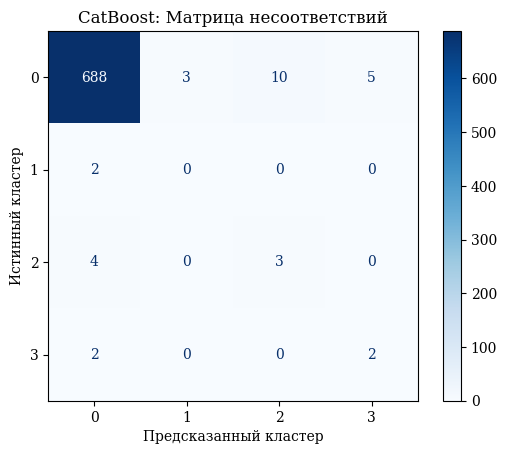

In [438]:
y_test_int = y_test.astype(int)
cm = confusion_matrix(y_test_int, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[int(label) for label in model_cat_best.classes_]
)

name = 'CatBoost'
disp.plot(cmap=plt.cm.Blues)
plt.title(name + ": Матрица несоответствий")
plt.ylabel('Истинный кластер')
plt.xlabel('Предсказанный кластер')
#plt.savefig(name + "_cm.pdf", bbox_inches='tight')
plt.show()

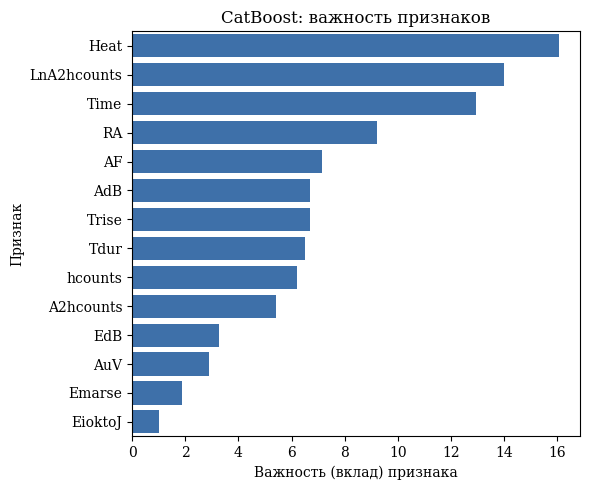

In [439]:
importances = model_cat.get_feature_importance()
feature_names = model_cat_best.feature_names_

feat_imp_df_cat = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feat_imp_df_cat = feat_imp_df_cat.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 5))
plt.title(name + ": важность признаков")
sns.barplot(x="Importance", y="Feature", data=feat_imp_df_cat, color='#2c6fbb')
plt.ylabel('Признак')
plt.xlabel('Важность (вклад) признака')
plt.tight_layout()
#plt.savefig(name + "_fi.pdf", bbox_inches='tight')
plt.show()

# II. Задача поиска аномалий (unsupervised)

## 1) Isolation forest

In [440]:
from sklearn.ensemble import IsolationForest

IsolationForest detected:
--------------------
Clust_0: 351 from 2015 pulses - 17%
Clust_1: 0 from 7 pulses - 0%
Clust_2: 10 from 21 pulses - 48%
Clust_3: 9 from 10 pulses - 90%
--------------------
contamination = 18.0%


<Figure size 1000x800 with 0 Axes>

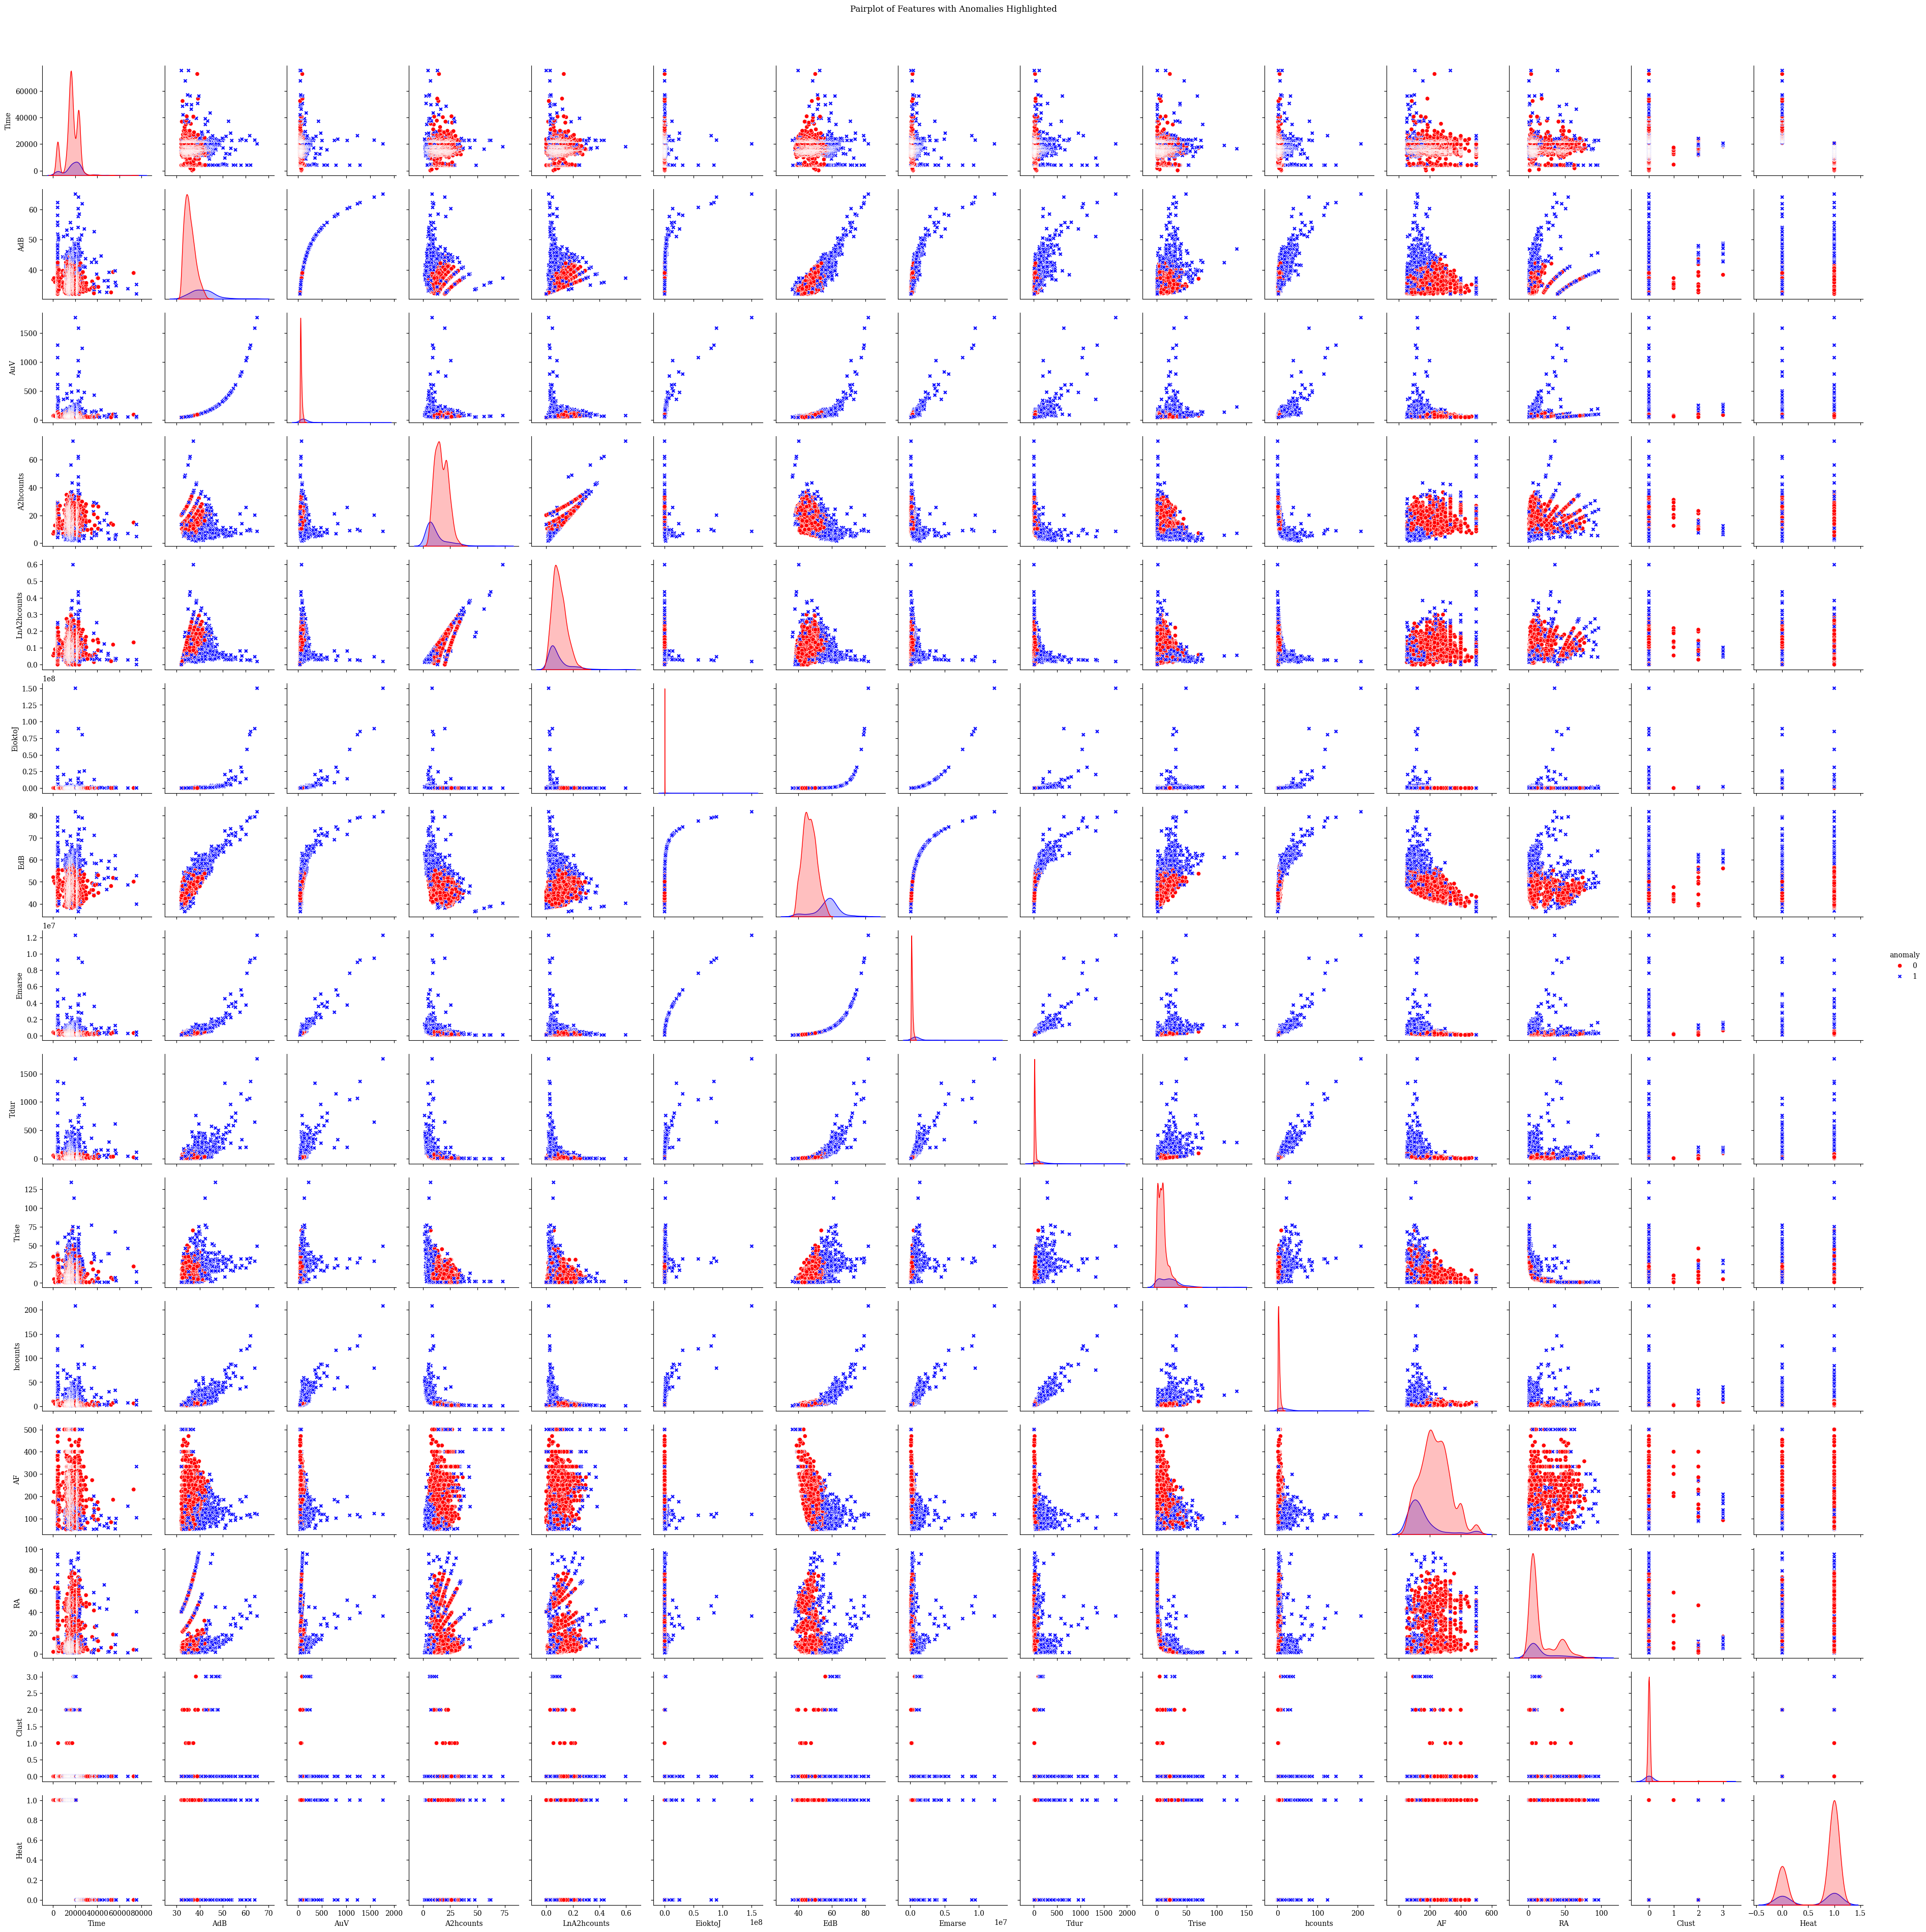

In [464]:
def IF_full(df, colname='Clust', pl=False, contamination=None):
    x = df.drop(columns=[colname]) # use .values or .to_numpy() to make np array
    y = df[colname]
    if not contamination:
        contamination = round(df.where(df[colname] != 0).dropna().shape[0] / df.shape[0], 2) + 0.01 # "с запасом"
        #print(contamination)

    model_IF = IsolationForest(contamination=contamination, max_samples=100, random_state=42)
    model_IF.fit(x)

    y_pred = model_IF.predict(x)
    y_pred = (y_pred == -1).astype(int)
    anomaly_df = pd.DataFrame({'y_true': y, 'y_pred': y_pred})
    #print(anomaly_df.where(anomaly_df.y_true != 0).dropna())

    # results:
    print('IsolationForest detected:', '-'*20, sep='\n')
    for i in range(4):
        cl_pred = anomaly_df.where((anomaly_df.y_pred == 1)&(anomaly_df.y_true == i)).dropna().shape[0]
        cl_true = anomaly_df.where(anomaly_df.y_true == i).dropna().shape[0]
        print(f'Clust_{i}: {cl_pred} from {cl_true} pulses - {int(round(cl_pred/cl_true, 2)*100)}%')
    print('-'*20, f'contamination = {round(contamination*100, 1)}%', sep='\n')

    test_df = pd.DataFrame(x, columns=df.columns)
    test_df['Clust'] = y.values
    test_df['anomaly'] = anomaly_df['y_pred']
    if pl:
        plt.figure(figsize=(10, 8))
        sns.pairplot(test_df, hue='anomaly', palette={0: 'red', 1: 'blue'}, markers=['o', 'X']) # blue - anomaly
        plt.suptitle("Pairplot of Features with Anomalies Highlighted", y=1.02)
        plt.show()

IF_full(df, contamination=0.18, pl=True)

## 2) One Class SVM

In [443]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [447]:
def SVM_full(df, colname='Clust', contamination=None):
    nu = contamination
    x = df.drop(columns=[colname]) # use .values or .to_numpy() to make np array
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    y = df[colname]
    if not nu:
        nu = round(df.where(df[colname] != 0).dropna().shape[0] / df.shape[0], 2) + 0.01 # "с запасом"

    ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=nu)  # Adjust nu as contamination
    ocsvm.fit(x_scaled)

    y_pred = ocsvm.predict(x_scaled)
    y_pred = (y_pred == -1).astype(int)
    anomaly_svm = pd.DataFrame({'y_true': y, 'y_pred': y_pred})

    print('SVM detected:', '-'*20, sep='\n')
    for i in range(4):
        cl_pred = anomaly_svm.where((anomaly_svm.y_pred == 1)&(anomaly_svm.y_true == i)).dropna().shape[0]
        cl_true = anomaly_svm.where(anomaly_svm.y_true == i).dropna().shape[0]
        print(f'Clust_{i}: {cl_pred} from {cl_true} pulses - {int(round(cl_pred/cl_true, 2)*100)}%')
    print('-'*20, f'nu = {round(nu*100, 1)}%', sep='\n')

SVM_full(df, contamination=0.18)

SVM detected:
--------------------
Clust_0: 358 from 2015 pulses - 18%
Clust_1: 0 from 7 pulses - 0%
Clust_2: 6 from 21 pulses - 28%
Clust_3: 5 from 10 pulses - 50%
--------------------
nu = 18.0%


##  3) Local Outlier Factor (LOF)

In [448]:
from sklearn.neighbors import LocalOutlierFactor

In [449]:
def LOF_full(df, colname='Clust', contamination=None, pl=False):
    x = df.drop(columns=[colname]) # use .values or .to_numpy() to make np array
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    y = df[colname]
    if not contamination:
        contamination = round(df.where(df[colname] != 0).dropna().shape[0] / df.shape[0], 2) + 0.01 # "с запасом"

    lof = LocalOutlierFactor(n_neighbors=30, contamination=contamination)

    y_pred = lof.fit_predict(x_scaled)
    y_pred = (y_pred == -1).astype(int)
    anomaly_svm = pd.DataFrame({'y_true': y, 'y_pred': y_pred})
    #print(anomaly_svm.where(anomaly_svm.y_true != 0).dropna())

    print('LOF detected:', '-'*20, sep='\n')
    for i in range(4):
        cl_pred = anomaly_svm.where((anomaly_svm.y_pred == 1)&(anomaly_svm.y_true == i)).dropna().shape[0]
        cl_true = anomaly_svm.where(anomaly_svm.y_true == i).dropna().shape[0]
        print(f'Clust_{i}: {cl_pred} from {cl_true} pulses - {int(round(cl_pred/cl_true, 2)*100)}%')
    print('-'*20, f'contamination = {round(contamination*100, 1)}%', sep='\n')

    if pl:
        plt.figure(figsize=(10, 8))
        sns.pairplot(test_df, hue='anomaly', palette={0: 'red', 1: 'blue'}, markers=['o', 'X']) # blue - anomaly
        plt.suptitle("Pairplot of Features with Anomalies Highlighted", y=1.02)
        plt.show()
LOF_full(df, contamination=0.18, pl=False)

LOF detected:
--------------------
Clust_0: 362 from 2015 pulses - 18%
Clust_1: 3 from 7 pulses - 43%
Clust_2: 4 from 21 pulses - 19%
Clust_3: 1 from 10 pulses - 10%
--------------------
contamination = 18.0%


Запустим все модели вместе для удобства сравнения:

In [451]:
contamination = 0.18
IF_full(df, contamination=contamination, pl=False)
print('', '|'*40, '', sep='\n')
SVM_full(df, contamination=contamination)
print('', '|'*40, '', sep='\n')
LOF_full(df, contamination=contamination)

IsolationForest detected:
--------------------
Clust_0: 351 from 2015 pulses - 17%
Clust_1: 0 from 7 pulses - 0%
Clust_2: 10 from 21 pulses - 48%
Clust_3: 9 from 10 pulses - 90%
--------------------
contamination = 18.0%

||||||||||||||||||||||||||||||||||||||||

SVM detected:
--------------------
Clust_0: 358 from 2015 pulses - 18%
Clust_1: 0 from 7 pulses - 0%
Clust_2: 6 from 21 pulses - 28%
Clust_3: 5 from 10 pulses - 50%
--------------------
nu = 18.0%

||||||||||||||||||||||||||||||||||||||||

LOF detected:
--------------------
Clust_0: 362 from 2015 pulses - 18%
Clust_1: 3 from 7 pulses - 43%
Clust_2: 4 from 21 pulses - 19%
Clust_3: 1 from 10 pulses - 10%
--------------------
contamination = 18.0%


# III. Кластеризация выделенных аномалий

## 1) K-means

In [452]:
from sklearn.cluster import KMeans

In [453]:
def IF_anomaly(df, colname='Clust', pl=False, contamination=None):
    x = df.drop(columns=[colname]) # use .values or .to_numpy() to make np array
    y = df[colname]
    if not contamination:
        contamination = round(df.where(df[colname] != 0).dropna().shape[0] / df.shape[0], 2) + 0.01 # "с запасом"
        #print(contamination)

    model_IF = IsolationForest(contamination=contamination, max_samples=100, random_state=42)
    model_IF.fit(x)

    y_pred = model_IF.predict(x)
    y_pred = (y_pred == -1).astype(int)
    anomaly_df = pd.DataFrame({'y_true': y, 'y_pred': y_pred})

    # results:
    print('IsolationForest detected:', '-'*20, sep='\n')
    for i in range(4):
        cl_pred = anomaly_df.where((anomaly_df.y_pred == 1)&(anomaly_df.y_true == i)).dropna().shape[0]
        cl_true = anomaly_df.where(anomaly_df.y_true == i).dropna().shape[0]
        print(f'Clust_{i}: {cl_pred} from {cl_true} pulses - {int(round(cl_pred/cl_true, 2)*100)}%')
    print('-'*20, f'contamination = {round(contamination*100, 1)}%', sep='\n')

    test_df = pd.DataFrame(x, columns=df.columns)
    test_df['Clust'] = y.values
    test_df['anomaly'] = anomaly_df['y_pred']

    return test_df.where(test_df['anomaly'] == 1).drop(columns=['anomaly']).dropna()

# Create dataset with anomalies
anomaly_data = IF_anomaly(df, contamination=0.18)

IsolationForest detected:
--------------------
Clust_0: 351 from 2015 pulses - 17%
Clust_1: 0 from 7 pulses - 0%
Clust_2: 10 from 21 pulses - 48%
Clust_3: 9 from 10 pulses - 90%
--------------------
contamination = 18.0%


In [454]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(anomaly_data)
anomaly_data['kmeans_labels'] = kmeans_labels

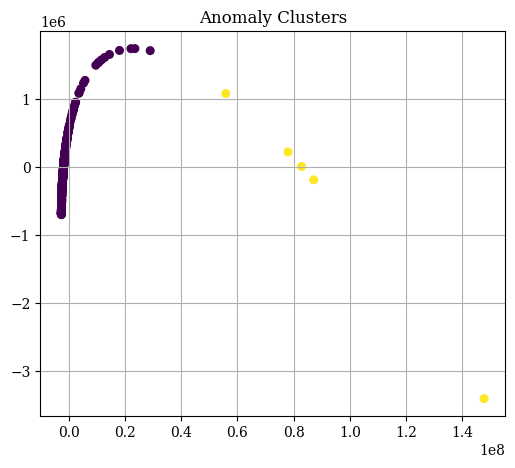

In [455]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(anomaly_data)

plt.figure(figsize=(6,5))
plt.scatter(reduced[:,0], reduced[:,1], c=kmeans_labels, cmap='viridis', s=30)
plt.title('Anomaly Clusters')
plt.grid(True)
plt.show()

## 2) DBSCAN

In [456]:
from sklearn.cluster import DBSCAN

In [457]:
dbscan = DBSCAN(eps=10**(7), min_samples=5)
dbscan_labels = dbscan.fit_predict(anomaly_data)
anomaly_data['dbscan_labels'] = dbscan_labels

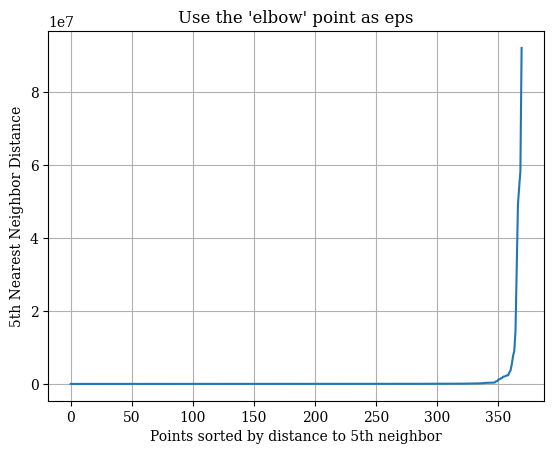

In [458]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(anomaly_data)
distances, indices = neighbors_fit.kneighbors(anomaly_data)

distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.xlabel("Points sorted by distance to 5th neighbor")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Use the 'elbow' point as eps")
plt.grid(True)
plt.show()

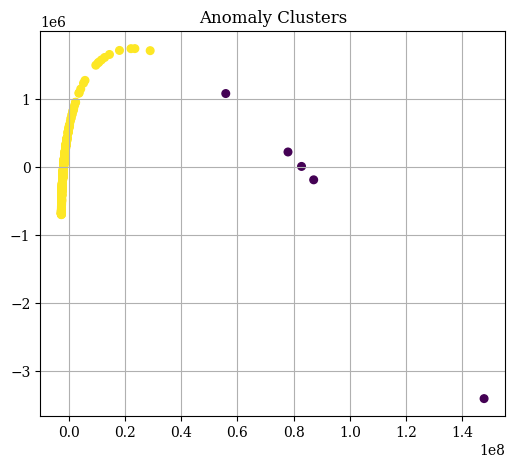

In [459]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(anomaly_data)

plt.figure(figsize=(6,5))
plt.scatter(reduced[:,0], reduced[:,1], c=dbscan_labels, cmap='viridis', s=30)
plt.title('Anomaly Clusters')
plt.grid(True)
plt.show()